<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Домашнее задание можно разделить на следующие части:

* Построй свой первый бейзлайн! [6]
  * BCE Loss [2]
  * SegNet [2]
  * Train [1]
  * Test [1]
* Мир других лоссов! [2]
  * Dice Loss [1]
  * Focal Loss [1]
  * BONUS: лосс из статьи [5]
* Новая модель! [2]
  * UNet [2]


**Максимальный балл:** 10 баллов.

Также для студентов желающих еще более углубиться в задачу предлагается решить бонусное задание, которое даст дополнительные 5 баллов. BONUS задание необязательное.


In [ ]:
#!rm -rf "/content/drive/MyDrive/chicago_patches"

In [1]:
import torch
#device = torch.device('cpu')
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#print(device)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# -o/content/chicago_data — это путь к папке, куда распакуются файлы
# В кавычках укажите ваш путь к архиву на Диске
#!7z x "/content/drive/MyDrive/chicago_patches.7z" -o/content/drive/MyDrive/
!7z x "/content/drive/MyDrive/chicago_patches.7z" -o/content/chicago_data


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.00GHz (50653),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 file, 1608607009 bytes (1535 MiB)

Extracting archive: /content/drive/MyDrive/chicago_patches.7z
--
Path = /content/drive/MyDrive/chicago_patches.7z
Type = 7z
Physical Size = 1608607009
Headers Size = 202432
Method = LZMA2:24
Solid = +
Blocks = 1

  0%      0% 3        0% 32 - chicago_patches/images/chicago10_patch_10_18.png                                                            0% 61 - chicago_patches/images/chicago10_patch_12_1.png 

In [4]:
!pip install -q segmentation_models_pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 13.0 MB/s eta 0:00:00


In [5]:
import os
import cv2
import torch
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import segmentation_models_pytorch as smp

In [ ]:
# 1. Пути к данным
#IMAGE_DIR = '/content/drive/MyDrivechicago_patches/images'
#MASK_DIR = '/content/drive/MyDrive/chicago_patches/masks'

In [6]:
# 1. Пути к данным
IMAGE_DIR = '/content/chicago_data/chicago_patches/images'
MASK_DIR = '/content/chicago_data/chicago_patches/masks'

In [7]:
# 2. Определение класса Dataset
class ChicagoDataset(Dataset):
    def __init__(self, image_filenames, image_dir, mask_dir, transform=None):
        self.image_filenames = image_filenames
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        # Загрузка изображения
        img_name = self.image_filenames[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # В RGB

        # Загрузка маски
        mask_path = os.path.join(self.mask_dir, img_name)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        # Бинаризация маски (0 или 1)
        mask = (mask > 0).astype(np.float32)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        # Возвращаем маску с размерностью [1, H, W] для PyTorch
        return image, mask.unsqueeze(0)

In [8]:
# 3. Настройка трансформаций (Нормализация)
# Используем стандартные значения ImageNet
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),  # Легкая аугментация для обучения
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

val_transform = A.Compose([
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

In [9]:
# 4. Разбиение на выборки
all_files = [f for f in os.listdir(IMAGE_DIR) if f.endswith('.png')]

#train_files, val_files = train_test_split(all_files, test_size=0.2, random_state=42)

#print(f"Всего патчей: {len(all_files)}")
#print(f"Обучение: {len(train_files)}")
#print(f"Валидация: {len(val_files)}")

In [10]:
import random
# 1. Получаем список уникальных имен снимков
all_images = sorted(list(set([f.split('_patch')[0] for f in all_files])))
print('VSE  ',all_images)

# 2. Разбиваем именно снимки (например, 30 на обучение, 6 на валидацию)
random.seed(42)
random.shuffle(all_images)
train_img_names = all_images[:31]

val_img_names = all_images[31:]
print('VAL   ',val_img_names)
####################################
# 3. Распределяем патчи по спискам
train_files = [f for f in all_files if f.split('_patch')[0] in train_img_names]
val_files = [f for f in all_files if f.split('_patch')[0] in val_img_names]

print(f"Снимки для обучения: {train_img_names}")
print(f"Снимки для валидации: {val_img_names}")

VSE   ['chicago1', 'chicago10', 'chicago11', 'chicago12', 'chicago13', 'chicago14', 'chicago15', 'chicago16', 'chicago17', 'chicago18', 'chicago19', 'chicago2', 'chicago20', 'chicago21', 'chicago22', 'chicago23', 'chicago24', 'chicago25', 'chicago26', 'chicago27', 'chicago28', 'chicago29', 'chicago3', 'chicago30', 'chicago31', 'chicago32', 'chicago33', 'chicago34', 'chicago35', 'chicago36', 'chicago4', 'chicago5', 'chicago6', 'chicago7', 'chicago8', 'chicago9']
VAL    ['chicago22', 'chicago23', 'chicago25', 'chicago10', 'chicago16']
Снимки для обучения: ['chicago18', 'chicago20', 'chicago14', 'chicago34', 'chicago6', 'chicago27', 'chicago4', 'chicago32', 'chicago3', 'chicago33', 'chicago5', 'chicago19', 'chicago2', 'chicago35', 'chicago17', 'chicago28', 'chicago24', 'chicago9', 'chicago15', 'chicago31', 'chicago1', 'chicago8', 'chicago21', 'chicago26', 'chicago11', 'chicago7', 'chicago36', 'chicago29', 'chicago12', 'chicago30', 'chicago13']
Снимки для валидации: ['chicago22', 'chicago2

In [11]:
print(f"Всего патчей: {len(all_files)}")
print(f"Обучение: {len(train_files)}")
print(f"Валидация: {len(val_files)}")

Всего патчей: 11307
Обучение: 9657
Валидация: 1650


In [12]:
# 5. Создание объектов Dataset и DataLoader
train_dataset = ChicagoDataset(train_files, IMAGE_DIR, MASK_DIR, transform=train_transform)
val_dataset = ChicagoDataset(val_files, IMAGE_DIR, MASK_DIR, transform=val_transform)

# На CPU лучше не ставить слишком большой batch_size. 4-8 будет достаточно.
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [13]:
# 6. Проверка (опционально)
image, mask = next(iter(train_loader))
print(f"Размер батча изображений: {image.shape}")  # [8, 3, 256, 256]
print(f"Размер батча масок: {mask.shape}")  # [8, 1, 256, 256]

Размер батча изображений: torch.Size([32, 3, 256, 256])
Размер батча масок: torch.Size([32, 1, 256, 256])


In [14]:
import torch
import torch.nn as nn
import segmentation_models_pytorch as smp

class CombinedLoss(nn.Module):
    def __init__(self, bce_weight=0.5, dice_weight=0.5):
        super(CombinedLoss, self).__init__()
        # BCE с автоматическим применением Sigmoid для стабильности
        self.bce = nn.BCEWithLogitsLoss()

        # Dice Loss из библиотеки smp
        self.dice = smp.losses.DiceLoss(mode='binary', from_logits=True)

        self.bce_weight = bce_weight
        self.dice_weight = dice_weight

    def forward(self, logits, targets):
        # targets должны иметь тот же тип, что и logits (float)
        targets = targets.float()

        loss_bce = self.bce(logits, targets)
        loss_dice = self.dice(logits, targets)

        # Итоговая сумма с весами
        total_loss = (self.bce_weight * loss_bce) + (self.dice_weight * loss_dice)
        return total_loss

In [15]:
import torch
import torch.nn as nn

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        skip = self.conv(x)
        down = self.pool(skip)
        return skip, down

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # in_channels: сколько пришло снизу (например, 1024)
        # out_channels: сколько каналов хотим после апсэмплинга (512)
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        # После concat будет out_channels (от апсэмпла) + out_channels (от скипа) = out_channels * 2
        self.double_conv = DoubleConv(out_channels * 2, out_channels)

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1) # Склеиваем по каналам
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=1):
        super().__init__()
        # Энкодер
        self.down1 = DownSample(in_channels, 64)
        self.down2 = DownSample(64, 128)
        self.down3 = DownSample(128, 256)
        self.down4 = DownSample(256, 512)

        # Центр (Bottleneck)
        self.bottleneck = DoubleConv(512, 1024)

        # Декодер
        # Теперь передаем: сколько каналов НА ВХОДЕ в апсэмпл и сколько НА ВЫХОДЕ из всего блока
        self.up1 = UpSample(1024, 512)
        self.up2 = UpSample(512, 256)
        self.up3 = UpSample(256, 128)
        self.up4 = UpSample(128, 64)

        self.out = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        sk1, x = self.down1(x)
        sk2, x = self.down2(x)
        sk3, x = self.down3(x)
        sk4, x = self.down4(x)

        x = self.bottleneck(x)

        x = self.up1(x, sk4)
        x = self.up2(x, sk3)
        x = self.up3(x, sk2)
        x = self.up4(x, sk1)

        return self.out(x)

In [16]:
from tqdm.notebook import tqdm
def train_single_epoch(model, optimizer, criterion, train_dataloader, device,loss_type):
    model.train()
    nnn=0
    avg_loss = 0
    for X_batch, Y_batch in tqdm(train_dataloader):
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        Y_pred = model(X_batch)

#        if loss_type==1: #   BCE logits
        #loss = criterion(Y_pred, Y_batch.to(torch.float)) # forward-pass  y_true.to(torch.float))
        #loss = criterion(Y_pred, Y_batch.to(torch.float)) # DICE
        loss = criterion(Y_pred, Y_batch.to(torch.float)) # JaccardLoss
#        if loss_type==2:  # DICE torch
#          loss=criterion(Y_pred, Y_batch.to(int))
#        if loss_type==3:  # Focal Loss
#          loss=criterion(Y_pred, Y_batch, alpha=-1, gamma=2, reduction='sum')
#        if loss_type==4: #Dice hand function
#          loss=criterion(Y_pred, Y_batch)
#        if loss_type==5: #Artical score alfa=1 betta=1
#          loss=criterion(Y_pred,Y_batch,alfa=1,betta=1)

        loss.backward()  # backward-pass
        optimizer.step()  # update weights
        optimizer.zero_grad() # set parameter gradients to zero

        avg_loss += loss.item()
        #nnn+=1
        #print(nnn,len(train_dataloader),loss.item())

    avg_loss = avg_loss/len(train_dataloader)

    return avg_loss

In [17]:
import matplotlib.pyplot as plt

def visualize_results(model, dataloader, device, epoch, num_samples=3):
    model.eval()
    # Берем один батч из валидатора
    images, masks = next(iter(dataloader))

    images = images.to(device)
    masks = masks.to(device)

    with torch.no_grad():
        logits = model(images)
        preds = torch.sigmoid(logits) > 0.5  # Бинаризация предсказания

    # Переводим в numpy для отрисовки
    images = images.cpu().permute(0, 2, 3, 1).numpy()
    masks = masks.cpu().numpy()
    preds = preds.cpu().numpy()

    # Стандартные значения денормировки (ImageNet)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    plt.figure(figsize=(12, 12))
    plt.suptitle(f'Epoch {epoch} - Visualization', fontsize=16)

    for i in range(num_samples):
        # 1. Оригинальное фото (Денормировка)
        img = images[i] * std + mean
        img = np.clip(img, 0, 1)  # Обрезаем лишнее, чтобы не было ошибок

        # 2. Истинная маска
        gt = masks[i][0]

        # 3. Предсказание модели
        pred = preds[i][0]

        # Ряд i, Колонка 1: Оригинал
        plt.subplot(3, 3, i * 3 + 1)
        plt.imshow(img)
        plt.title("Original Photo")
        plt.axis('off')

        # Ряд i, Колонка 2: Маска (Ground Truth)
        plt.subplot(3, 3, i * 3 + 2)
        plt.imshow(gt, cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')

        # Ряд i, Колонка 3: Предсказание
        plt.subplot(3, 3, i * 3 + 3)
        plt.imshow(pred, cmap='gray')
        plt.title("Model Prediction")
        plt.axis('off')

    plt.tight_layout()
    plt.show()
  #  plt.savefig(f'epoch_{epoch}.png')

In [18]:
def train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, device,loss_type, plot_every=5):

    total_train_loss = []
    total_val_loss = []
    total_val_iou = []

    best_val_loss = float('inf')
    best_val_iou = 0

    for epoch in tqdm(range(106,epochs)):

        train_loss = train_single_epoch(model, optimizer, criterion, train_dataloader, device,loss_type)
        total_train_loss.append(train_loss)

        print(f'Epoch {epoch}: train loss = {train_loss}')

        # ВИЗУАЛИЗАЦИЯ: каждые plot_every эпох
        # Также рисуем на самой первой эпохе (0), чтобы увидеть начальное состояние
        if epoch == 0 or (epoch) % plot_every == 0:
            visualize_results(model, valid_dataloader, device, epoch , num_samples=3)
            # Переключаем модель обратно в режим обучения после валидации/визуализации
            model.train()

        if (epoch) % 5 == 0:
            checkpoint_path = f"/content/drive/MyDrive/checkpoint_epoch_{epoch}.pth"
            torch.save(model.state_dict(), checkpoint_path)
            print(f"--- Модель сохранена в {checkpoint_path} ---")

    return model, total_train_loss

In [19]:
# 1. Определяем устройство
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
print(f"Using device: {device}")

# 2. Создаем модель и сразу отправляем на устройство
model = UNet().to(device)

Using device: cuda


In [21]:
#3. Загружаем чекпоинт
# map_location гарантирует, что веса загрузятся правильно на CPU или GPU
checkpoint = torch.load(f"/content/drive/MyDrive/checkpoint_epoch_105.pth", map_location=device)
model.load_state_dict(checkpoint)
print("Модель загружена.")

Модель загружена.


In [22]:
# 4. Настраиваем лосс и оптимизатор
#criterion = nn.BCEWithLogitsLoss(reduction='mean')
#criterion = smp.losses.DiceLoss(mode='binary', from_logits=True)
#criterion = smp.losses.JaccardLoss(mode='binary', from_logits=True)
criterion = CombinedLoss(bce_weight=0.5, dice_weight=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

# 5. Остальные параметры
loss_type = 1
epochs = 150

In [ ]:
model, statisticsSEGNET = train(model, optimizer, criterion, epochs, train_loader, val_loader, device,loss_type,5)

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/302 [00:00<?, ?it/s]

ОБРАБОТКА**********************

In [ ]:
!7z x "/content/drive/MyDrive/Chicago_orig.7z" -o/content/Chicago_orig



7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/MyDrive/                                 1 file, 1881240717 bytes (1795 MiB)

Extracting archive: /content/drive/MyDrive/Chicago_orig.7z
--
Path = /content/drive/MyDrive/Chicago_orig.7z
Type = 7z
Physical Size = 1881240717
Headers Size = 1107
Method = LZMA2:24
Solid = +
Blocks = 2

  0%      0% 9 - Chicago_orig/train/gt/chicago13.tif                                              0% 16 - Chicago_orig/train/gt/chicago2.tif                                              0% 18 - Chicago_orig/trai

In [ ]:
import os
import torch
import torch.nn as nn

##############################################################

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = DoubleConv(in_channels, out_channels)
        self.pool = nn.MaxPool2d(2)

    def forward(self, x):
        skip = self.conv(x)
        down = self.pool(skip)
        return skip, down

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # in_channels: сколько пришло снизу (например, 1024)
        # out_channels: сколько каналов хотим после апсэмплинга (512)
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2)
        # После concat будет out_channels (от апсэмпла) + out_channels (от скипа) = out_channels * 2
        self.double_conv = DoubleConv(out_channels * 2, out_channels)

    def forward(self, x, skip):
        x = self.up(x)
        x = torch.cat([x, skip], dim=1) # Склеиваем по каналам
        return self.double_conv(x)

class UNet(nn.Module):
    def __init__(self, in_channels=3, num_classes=1):
        super().__init__()
        # Энкодер
        self.down1 = DownSample(in_channels, 64)
        self.down2 = DownSample(64, 128)
        self.down3 = DownSample(128, 256)
        self.down4 = DownSample(256, 512)

        # Центр (Bottleneck)
        self.bottleneck = DoubleConv(512, 1024)

        # Декодер
        # Теперь передаем: сколько каналов НА ВХОДЕ в апсэмпл и сколько НА ВЫХОДЕ из всего блока
        self.up1 = UpSample(1024, 512)
        self.up2 = UpSample(512, 256)
        self.up3 = UpSample(256, 128)
        self.up4 = UpSample(128, 64)

        self.out = nn.Conv2d(64, num_classes, kernel_size=1)

    def forward(self, x):
        sk1, x = self.down1(x)
        sk2, x = self.down2(x)
        sk3, x = self.down3(x)
        sk4, x = self.down4(x)

        x = self.bottleneck(x)

        x = self.up1(x, sk4)
        x = self.up2(x, sk3)
        x = self.up3(x, sk2)
        x = self.up4(x, sk1)

        return self.out(x)

In [ ]:
# 1. Определяем устройство
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [ ]:
# 2. Создаем модель и сразу отправляем на устройство
model = UNet().to(device)

In [ ]:
#3. Загружаем чекпоинт
# map_location гарантирует, что веса загрузятся правильно на CPU или GPU
checkpoint = torch.load(f"/content/drive/MyDrive/checkpoint_epoch_105.pth", map_location=device)
model.load_state_dict(checkpoint)
print("Модель загружена.")

Модель загружена.


In [ ]:
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt

In [ ]:
def predict_full_image(model, image_path, mask_path, device, patch_size=256):
    # 1. Загрузка оригинального фото и маски
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Загружаем истинную маску (GT)
    gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    if gt_mask is None:
        raise FileNotFoundError(f"Маска не найдена по пути: {mask_path}")

    h, w, _ = image.shape  # 5000, 5000

    # --- РАСЧЕТ ПЛОЩАДИ ПО ИСТИННОЙ МАСКЕ (GT) ---
    # В масках Inria здания — это 255, фон — 0.
    # Делаем бинарную маску (0 и 1)
    gt_binary = (gt_mask > 0).astype(np.uint8)
    gt_pixel_count = np.sum(gt_binary)
    gt_area_m2 = gt_pixel_count * 0.09  # 0.3м * 0.3м = 0.09
    # ----------------------------------------------

    # 2. Padding (Дополнение до 5120 для модели)
    pad_h = (patch_size - h % patch_size) % patch_size
    pad_w = (patch_size - w % patch_size) % patch_size
    padded_img = cv2.copyMakeBorder(image, 0, pad_h, 0, pad_w, cv2.BORDER_CONSTANT, value=0)

    # 3. Подготовка холста для предсказаний
    full_pred = np.zeros((h + pad_h, w + pad_w), dtype=np.float32)

    model.eval()
    # Константы нормализации
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])

    with torch.no_grad():
        for y in range(0, padded_img.shape[0], patch_size):
            for x in range(0, padded_img.shape[1], patch_size):
                patch = padded_img[y:y + patch_size, x:x + patch_size]

                # Подготовка патча
                input_patch = patch / 255.0
                input_patch = (input_patch - mean) / std
                input_patch = torch.from_numpy(input_patch).permute(2, 0, 1).float().unsqueeze(0).to(device)

                # Предсказание
                output = model(input_patch)
                pred = torch.sigmoid(output).squeeze().cpu().numpy()
                full_pred[y:y + patch_size, x:x + patch_size] = pred

    # 4. Обрезка и бинаризация предсказания
    final_pred_mask = full_pred[:h, :w]
    binary_pred = (final_pred_mask > 0.5).astype(np.uint8)

    # --- РАСЧЕТ ПЛОЩАДИ ПО ПРЕДСКАЗАНИЮ МОДЕЛИ ---
    pred_pixel_count = np.sum(binary_pred)
    pred_area_m2 = pred_pixel_count * 0.09
    # ----------------------------------------------

    # Расчет разницы в процентах (ошибка)
    error_percent = abs(pred_area_m2 - gt_area_m2) / gt_area_m2 * 100

    return image, gt_mask, binary_pred, pred_area_m2, gt_area_m2, error_percent

In [ ]:
def plot_final_results(image, gt, pred, area,area_gt,filename):
    fig, ax = plt.subplots(1, 3, figsize=(20, 7))

    # Уменьшаем для отрисовки (например, до 1000x1000)
    preview_img = cv2.resize(image, (1000, 1000))
    preview_gt = cv2.resize(gt, (1000, 1000))
    preview_pred = cv2.resize(pred, (1000, 1000))

    ax[0].imshow(preview_img)
    ax[0].set_title("Оригинальный снимок")
    ax[0].axis('off')

    ax[1].imshow(preview_gt, cmap='gray')
    ax[1].set_title(f"Истинная маска (GT)-Площадь: {area_gt:,.0f} м²")
    ax[1].axis('off')

    ax[2].imshow(preview_pred, cmap='gray')
    ax[2].set_title(f"Предсказание модели-Площадь: {area:,.0f} м²")
    ax[2].axis('off')

    plt.tight_layout()
    plt.show()
    #plt.savefig(f'Ploshad-{filename}.png')

In [ ]:
# 1. Задаем пути к папкам '/content/Chicago_orig/train/images'
images_dir = '/content/Chicago_orig/Chicago_orig/train/images'
masks_dir = '/content/Chicago_orig/Chicago_orig/train/gt'

# 2. Выбираем файлы (например, снимки Чикаго с 30 по 36, которые не участвовали в обучении)
#test_files = [f for f in os.listdir(images_dir) if f.startswith('chicago') and f.endswith('.tif')]
#test_files = test_files[30:]  # Берем последние 6 файлов для теста
test_files = ['chicago22.tif', 'chicago23.tif', 'chicago25.tif', 'chicago10.tif', 'chicago16.tif']

Обработка chicago22.tif...


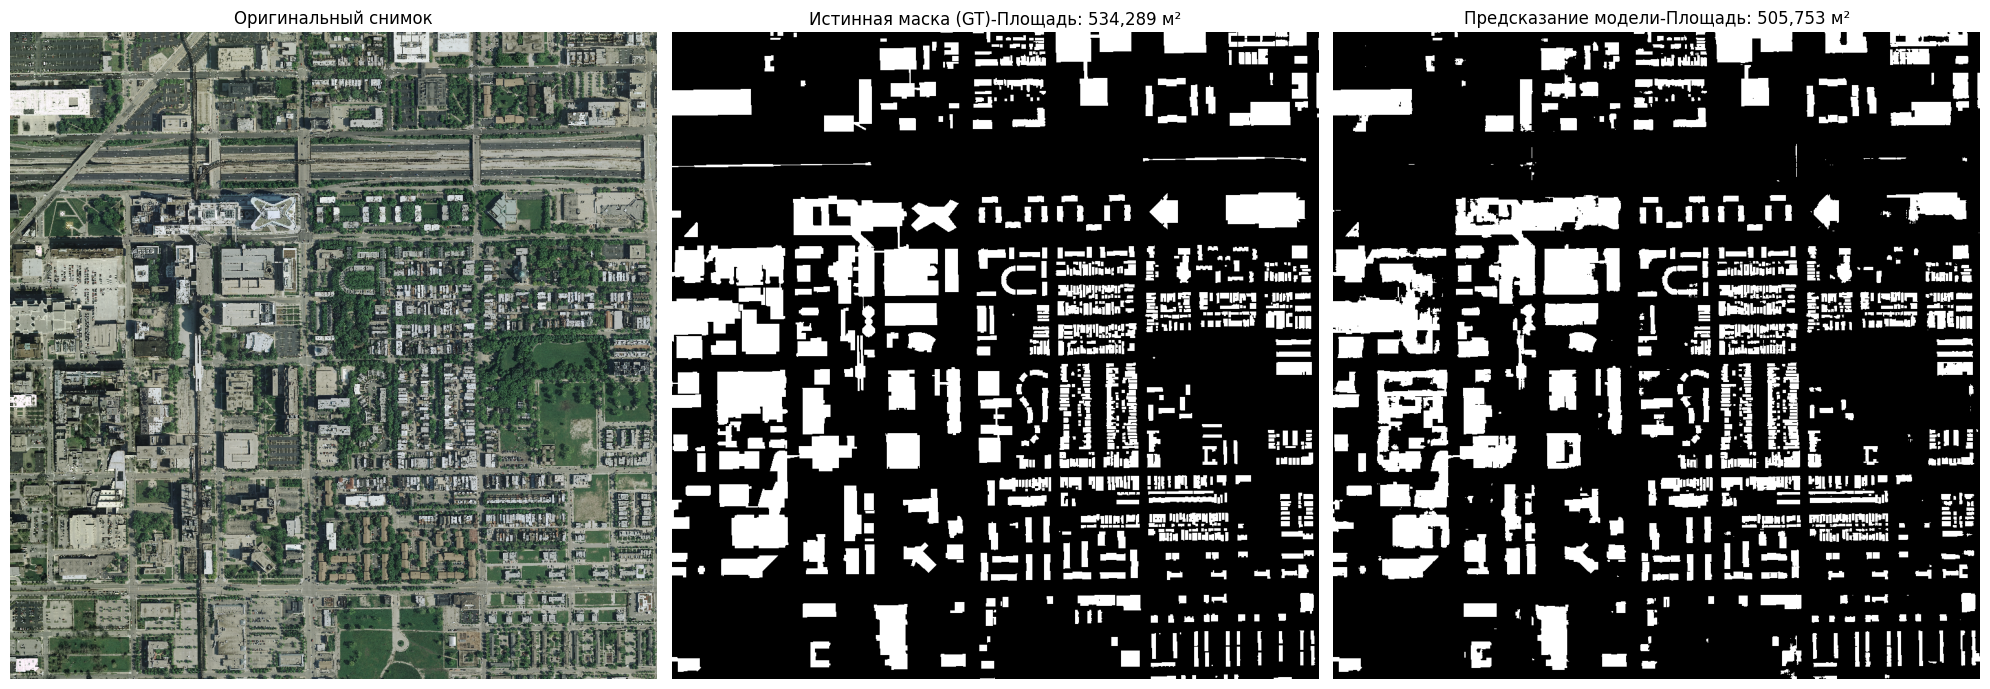

Обработка chicago23.tif...


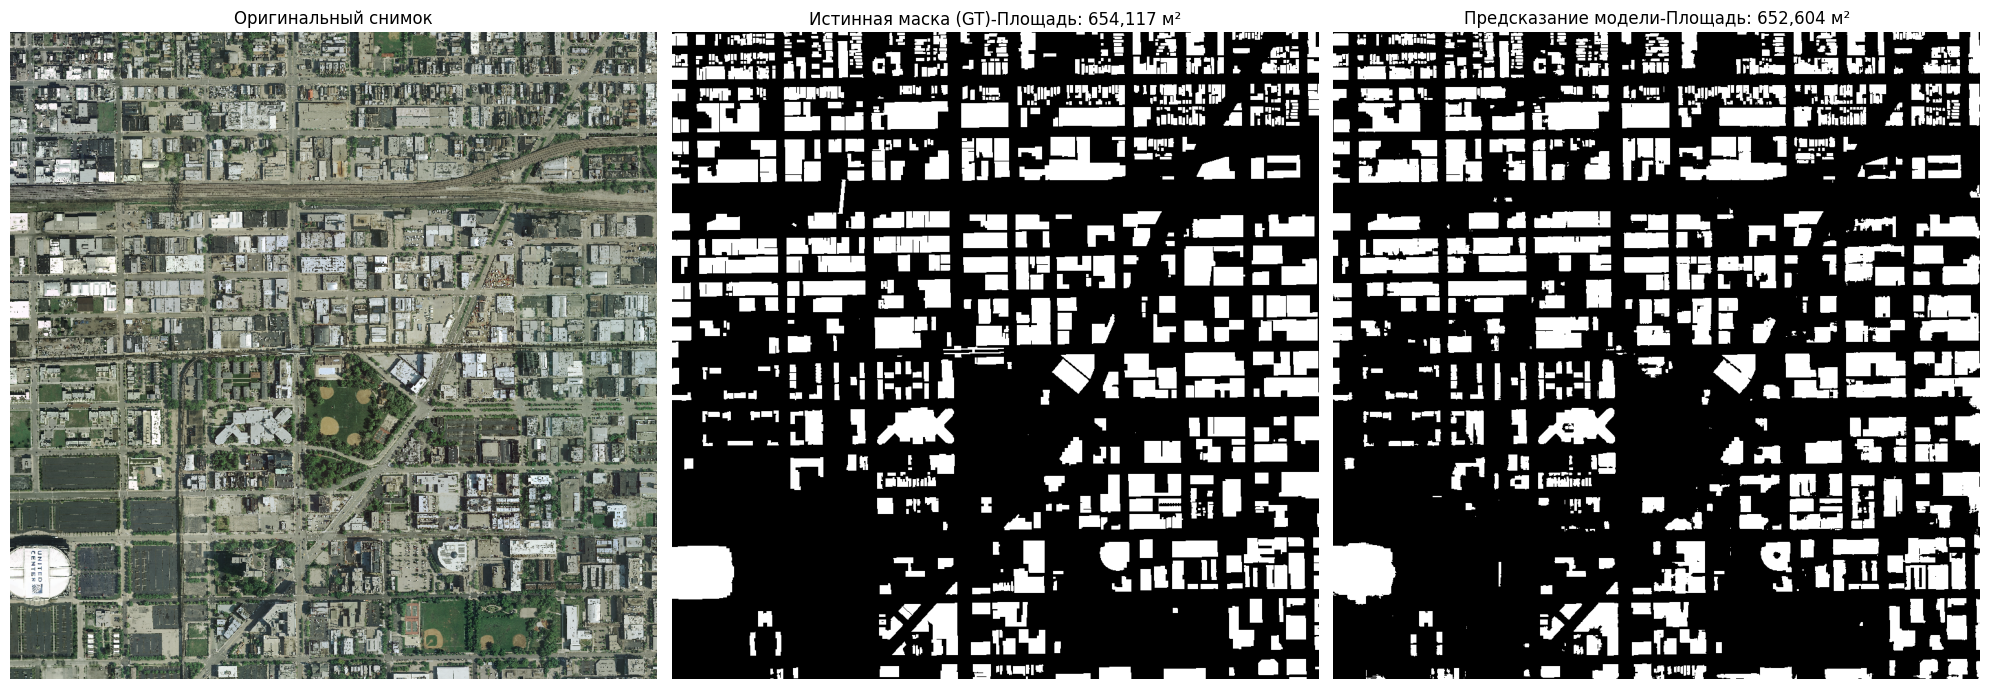

Обработка chicago25.tif...


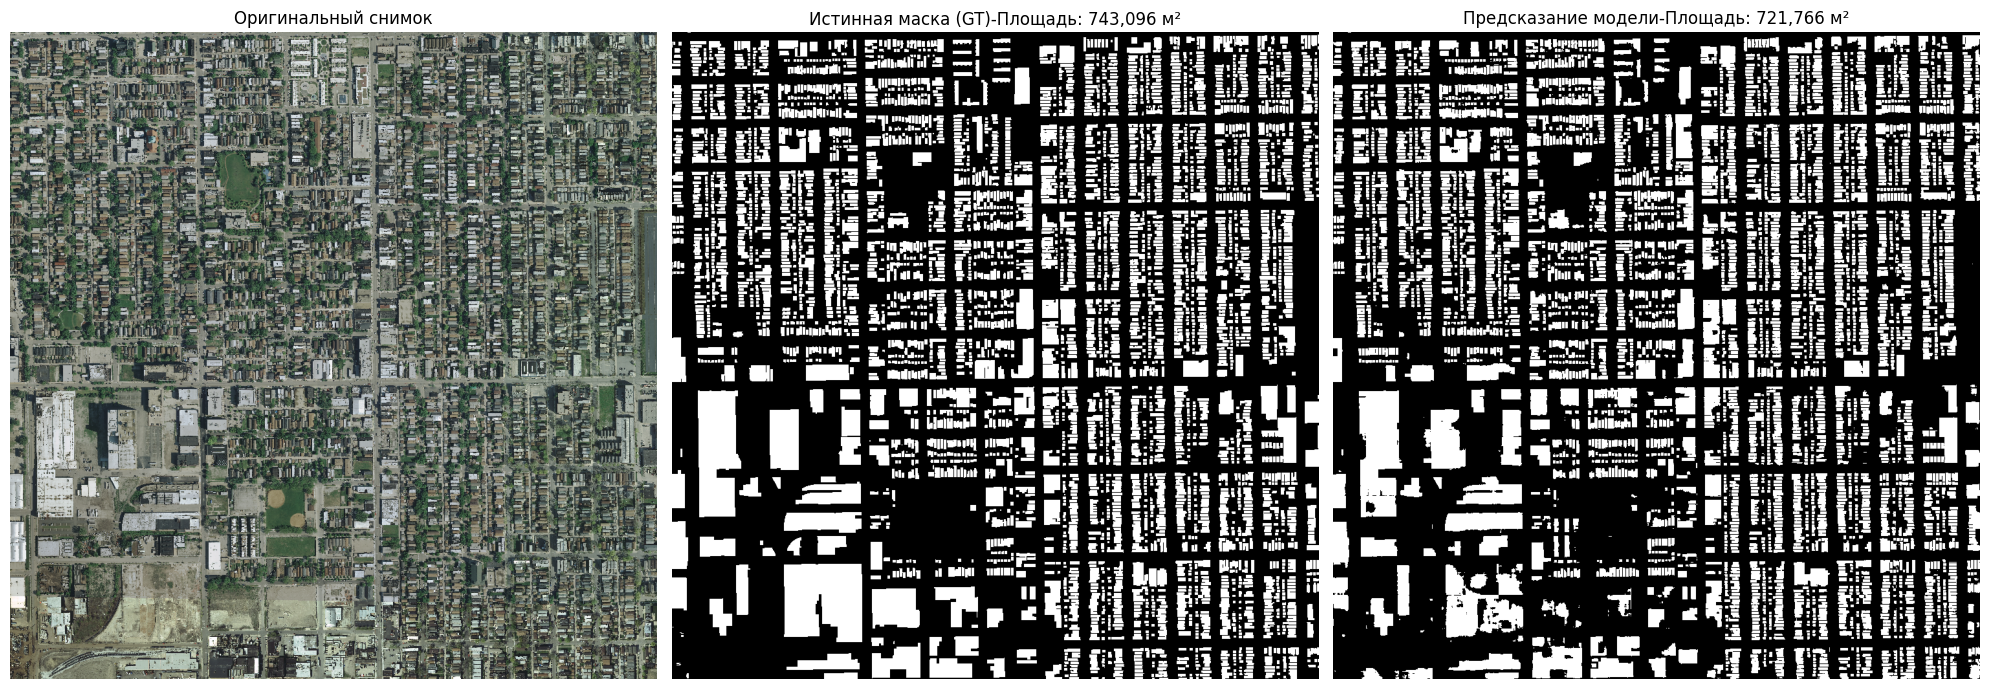

Обработка chicago10.tif...


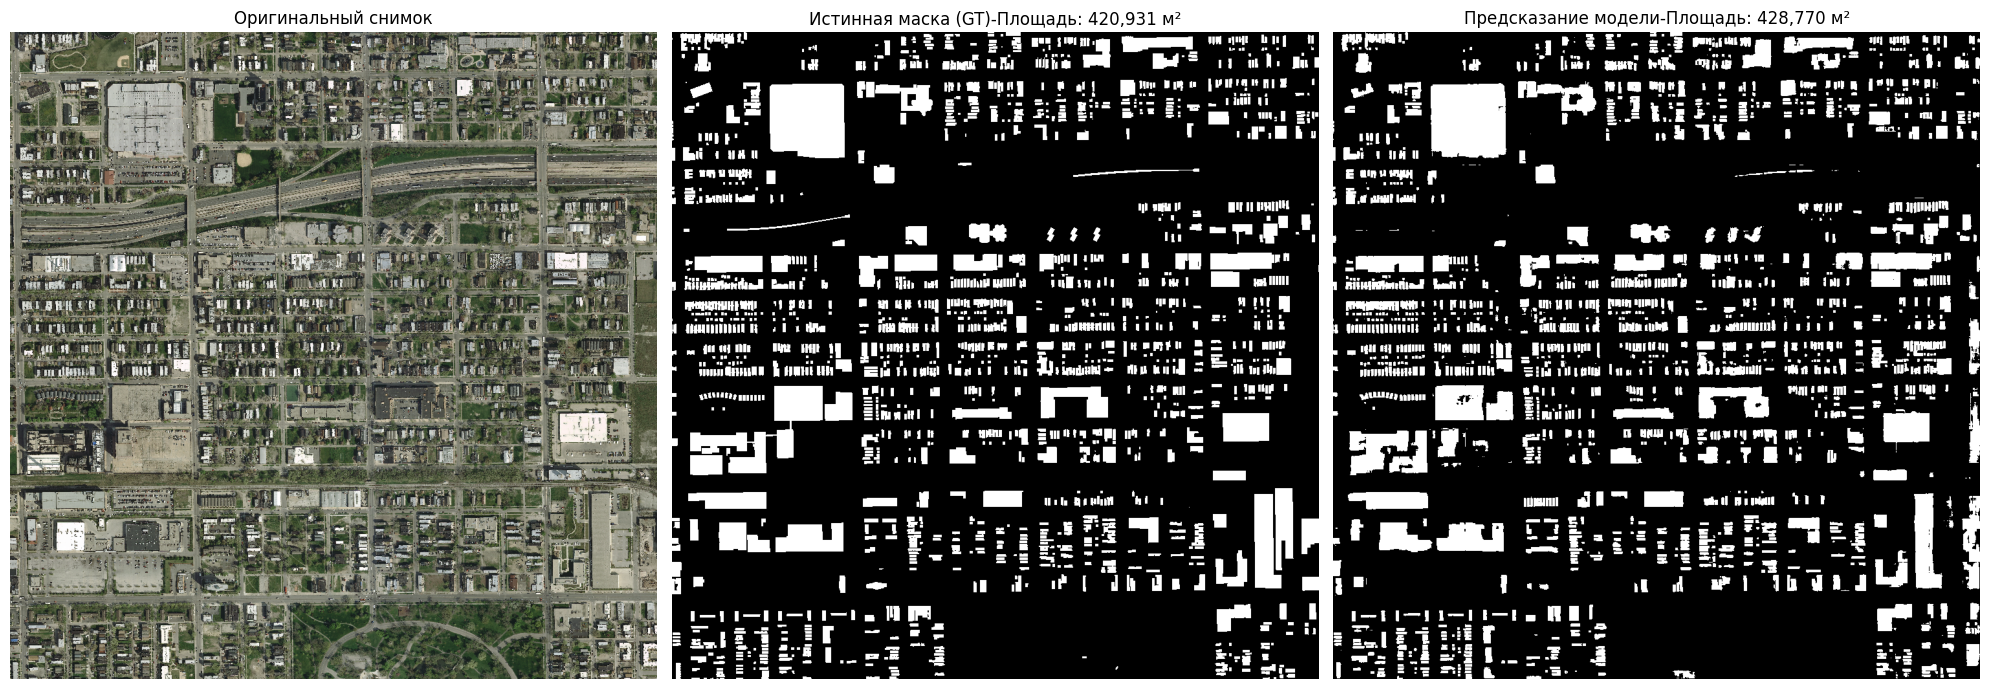

Обработка chicago16.tif...


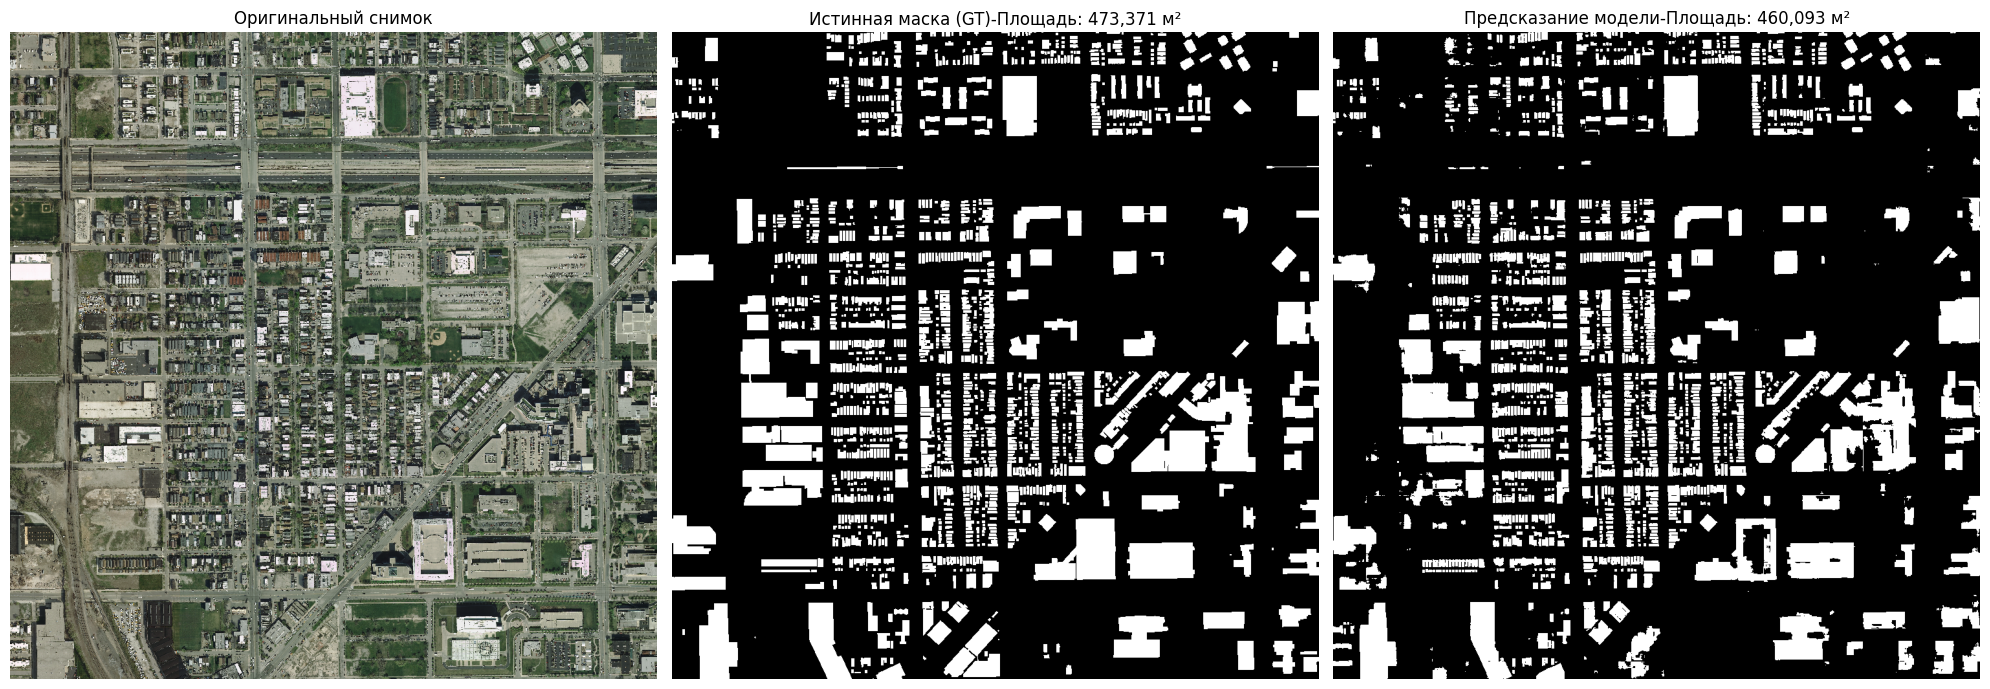

In [ ]:
all_areas = {}  # Словарь для хранения площадей

for filename in test_files:
    print(f"Обработка {filename}...")

    img_path = os.path.join(images_dir, filename)
    mask_path = os.path.join(masks_dir, filename)

    # Вызываем функцию (которую мы написали раньше)
    #image, gt, pred, area = predict_full_image(model, img_path, mask_path, device)
    image, gt, pred, area_model, area_gt, error = predict_full_image(model, img_path, mask_path, device)

    # Сохраняем результат в словарь
    all_areas[filename] = [area_model,area_gt,error]

    # Визуализируем (опционально)
    plot_final_results(image, gt, pred, area_model,area_gt,filename)

In [ ]:
# Вывод итогов
print("\nИтоговые площади застройки:")
print(all_areas)
#for name, val in all_areas.items():
#    print(f"{name}: {val:,.2f} м²")
for name, val in all_areas.items():
    print(f"{name}:")
    print(f"  Модель: {val [0] :,.2f} м²")
    print(f"  Факт:   {val [1] :,.2f} м²")
    print(f"  Ошибка: {val [2] :.2f}%")
    print("-" * 30) # Разделительная линия


Итоговые площади застройки:
{'chicago22.tif': [np.float64(505753.01999999996), np.float64(534288.87), np.float64(5.340902946378058)], 'chicago23.tif': [np.float64(652604.13), np.float64(654117.03), np.float64(0.23128888725004199)], 'chicago25.tif': [np.float64(721765.7999999999), np.float64(743095.7999999999), np.float64(2.8704239749437424)], 'chicago10.tif': [np.float64(428770.17), np.float64(420930.81), np.float64(1.862386837399711)], 'chicago16.tif': [np.float64(460092.95999999996), np.float64(473370.75), np.float64(2.8049451724678884)]}
chicago22.tif:
  Модель: 505,753.02 м²
  Факт:   534,288.87 м²
  Ошибка: 5.34%
------------------------------
chicago23.tif:
  Модель: 652,604.13 м²
  Факт:   654,117.03 м²
  Ошибка: 0.23%
------------------------------
chicago25.tif:
  Модель: 721,765.80 м²
  Факт:   743,095.80 м²
  Ошибка: 2.87%
------------------------------
chicago10.tif:
  Модель: 428,770.17 м²
  Факт:   420,930.81 м²
  Ошибка: 1.86%
------------------------------
chicago16.ti

# Вывод итогов
print("\nИтоговые площади застройки:")
print(all_areas)
#for name, val in all_areas.items():
#    print(f"{name}: {val:,.2f} м²")
for name, val in all_areas.items():
    print(f"{name}:")
    print(f"  Модель: {val [0] :,.2f} м²")
    print(f"  Факт:   {val [1] :,.2f} м²")
    print(f"  Ошибка: {val [2] :.2f}%")
    print("-" * 30) # Разделительная линия